## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [2]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [ ]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())
df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00049043| 39.3331| -120.173|   1774.9|-3401.545755094027|
|USC00041018| 39.4539|-120.6556|   1641.3|-7153.610531706802|
|USC00048331| 39.3167|-120.3833|   2058.9|-8773.588923209847|
|USC00048474|    39.2|-120.2333|   1902.9|-9674.075196949938|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(5)

station  latitude  longitude  elevation  count(station)  avg(coeff_1)
17  US1CAPC0001   39.3021  -120.3837     2099.2               1  -4773.255058
3   USC00040747   39.3000  -120.5167     1751.1               2  -5025.445267
12  USC00040931   39.3886  -120.0936     1699.3              45   -991.599223
33  USC00041018   39.4539  -120.6556     1641.3              43  -4434.549010
10  USC00041462   39.4500  -121.0500      839.7               2   -213.283775

In [8]:
q1 = "select min(latitude), min(longitude), max(latitude), max(longitude) FROM weather"
df2 = sqlContext.sql(q1)
df2.show(5)

+-------------+--------------+-------------+--------------+
|min(latitude)|min(longitude)|max(latitude)|max(longitude)|
+-------------+--------------+-------------+--------------+
|      39.1181|       -121.05|      39.8056|     -115.9622|
+-------------+--------------+-------------+--------------+



In [9]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:4]))

get_color(1005.)

u'#840000'

## Map

In [10]:
min_lat,max_lat,min_long,max_long = box = (39.1181, 39.8056, -121.05, -115.9622)


In [11]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
coeff_color={}

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    coeff_color[_coef]=get_color(_coef)
    circles.append(c)
    m.add_layer(c)
m    

In [12]:
from traitlets import (
    Float, Unicode )

a = TileLayer(url='http://stamen-tiles-{s}.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png', attribute='Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Map data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>')
m.add_layer(a)
m

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

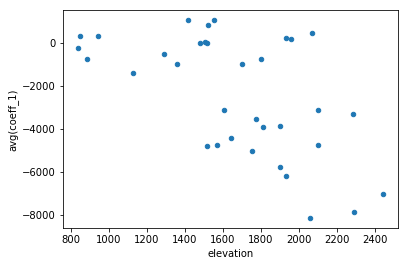

In [13]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

<IPython.core.display.Javascript object>